In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F


class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.convA( torch.cat([up_x, concat_with], dim=1)  ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=1664, decoder_width = 1.0):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=0)

        self.up1 = UpSample(skip_input=features//1 + 256, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 128,  output_features=features//4)
        self.up3 = UpSample(skip_input=features//4 + 64,  output_features=features//8)
        self.up4 = UpSample(skip_input=features//8 + 64,  output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)
        self.residual_block1 = self._make_residual_block(features // 1, features // 1)
        self.residual_block2 = self._make_residual_block(features // 2, features // 2)
        self.residual_block3 = self._make_residual_block(features // 4, features // 4)
        self.residual_block4 = self._make_residual_block(features // 8, features // 8)

    def _make_residual_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[3], features[4], features[6], features[8], features[12]
        x_d0 = self.conv2(F.relu(x_block4))
        x_d0 = self.residual_block1(x_d0)  
        x_d1 = self.up1(x_d0, x_block3) 
        x_d1 = self.residual_block2(x_d1)
        x_d2 = self.up2(x_d1, x_block2)
        x_d2 = self.residual_block3(x_d2)
        x_d3 = self.up3(x_d2, x_block1)
        x_d3 = self.residual_block4(x_d3)
        x_d4 = self.up4(x_d3, x_block0)
        return self.conv3(x_d4)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        self.original_model = models.densenet169( pretrained=False )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features

class Depth_Model(nn.Module):
    def __init__(self):
        super(Depth_Model, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder( self.encoder(x) )

In [ ]:
!pip install kornia

In [ ]:
import torch
import kornia.metrics as metrics
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from torch.autograd import Variable

def ssim(
    img1: torch.Tensor,
    img2: torch.Tensor,
    window_size: int,
    max_val: float = 100.0,
    eps: float = 1e-12,
    reduction: str = 'mean',
    padding: str = 'same',
) -> torch.Tensor:
    # Compute the SSIM map
    ssim_map = metrics.ssim(img1, img2, window_size, max_val, eps, padding)

    # Compute and reduce the loss
    loss = torch.clamp((1.0 - ssim_map) / 2, min=0, max=1)

    if reduction == 'mean':
        loss = torch.mean(loss)
    elif reduction == 'sum':
        loss = torch.sum(loss)
    elif reduction == 'none':
        pass

    return loss

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
from sklearn.utils import shuffle
import os

class NYUV2Dataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, base_dir, output_shape, transform=None):
        self.data = pd.read_csv(csv_file)
        self.base_dir = base_dir
        self.output_shape = output_shape
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        rgb_path = os.path.join(self.base_dir, self.data.iloc[idx, 0])
        depth_path = os.path.join(self.base_dir, self.data.iloc[idx, 1])
        
        rgb_image = Image.open(rgb_path).convert('RGB')
        depth_image = Image.open(depth_path).convert('L')
        
        depth_image = depth_image.resize((self.output_shape[3], self.output_shape[2]))
        
        if self.transform is not None:
            rgb_image = self.transform(rgb_image)
        
        depth_transform = transforms.Compose([
            transforms.ToTensor()
        ])
        depth_image = depth_transform(depth_image)

        return rgb_image, depth_image



csv_file = '/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train.csv'
base_dir = '/kaggle/input/nyu-depth-v2/nyu_data/'

transform = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor()
])
batch_size = 8
output_shape = (batch_size, 1, 240, 320)
nyu_dataset = NYUV2Dataset(csv_file, base_dir=base_dir, output_shape=output_shape, transform=transform)



data_loader = torch.utils.data.DataLoader(nyu_dataset, batch_size=batch_size, shuffle=True)



In [2]:
model = Depth_Model().cuda()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
learning_rate = 0.0001
optimizer = torch.optim.Adam( model.parameters(), learning_rate )

In [ ]:
def DepthNorm(depth, maxDepth=1000.0): 
    return maxDepth / depth

In [3]:
model.load_state_dict(torch.load('/kaggle/input/pegasisv5-per-ep-10/pegasisv5_epoch_10.pth'))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm

epochs = 4
l1_criterion = nn.L1Loss()

for epoch in range(epochs):
    total_loss = 0.0
    pbar = tqdm(data_loader, total=len(data_loader), desc=f"Epoch {epoch+1}/{epochs}")
    model.train()
    for batch in pbar:
        optimizer.zero_grad()
        inputs, targets = batch
        image = inputs.cuda()
        depth = targets.cuda(non_blocking=True)
        
        depth_n = DepthNorm( depth )

        output = model(image)
        output.shape
        depth_n.shape
        l_depth = l1_criterion(output, depth_n)
        l_ssim = torch.clamp((1 - ssim(output, depth_n, 11)) * 0.5, 0, 1)
        loss = (1.0 * l_ssim.mean().item()) + (0.1 * l_depth)
        #print(l_ssim.mean().item(),l_depth)
        #loss = (1.0 * l_ssim) + (0.1 * l_depth)


        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        pbar.set_postfix({'Loss': loss.item()})

    average_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {average_loss:.4f}")

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/pegasisv5_epoch_10.pth')

In [4]:
import torchvision.transforms as transforms
from PIL import Image

output_height, output_width = 480, 640

image = Image.open('/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_test/00014_colors.png')  # Replace 'your_image.jpg' with the path to your image
#image=Image.open('/content/1.jpg')
transform = transforms.Compose([
    transforms.Resize((output_height, output_width)),
    transforms.ToTensor()
])
image_tensor = transform(image)

image_tensor = image_tensor.unsqueeze(0)  # Add a batch dimension
image_tensor = image_tensor.permute(0, 2, 3, 1)  # Reshape from (1, 3, 480, 640) to (1, 480, 640, 3)
image_tensor = image_tensor.permute(0, 3, 1, 2)  # Reshape to the required shape (1, 3, 480, 640)
image_tensor = image_tensor.float()

In [5]:
with torch.no_grad():
    outputv3 = model(image_tensor.to("cuda"))

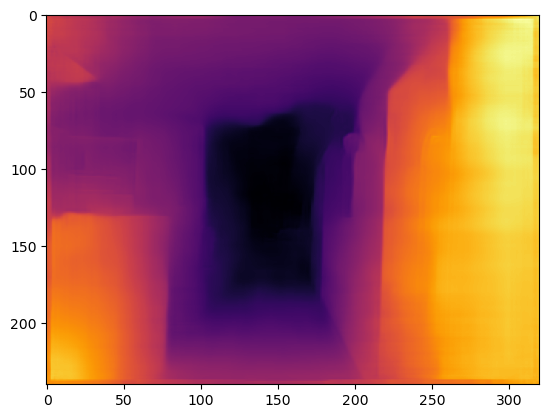

In [6]:
import matplotlib.pyplot as plt
output_reshaped = outputv3.squeeze().detach().cpu().numpy()
plt.imshow(output_reshaped, cmap='inferno')
#plt.imsave("/kaggle/working/pegasisv3_ep35.png",output_reshaped, cmap='inferno')